# Exploring the OSHA chemical monitoring dataset
### Author: Jeff Minucci
### Date: 9/9/2019

In [ ]:
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tabulate import tabulate
%matplotlib inline

### Load the dataset

In [83]:
if not 'data/osha/osha_monitoring_1984_2018.zip':
    with zipfile.ZipFile('data/osha/osha_monitoring_1984_2018.zip','r') as zfile:
        zfile.extractall('data/osha')
osha = pd.read_csv('data/osha/osha_monitoring_1984_2018.csv')

### Clean and organize the data

In [88]:
osha.drop(osha.columns[0], axis=1, inplace=True) #drop first column of old indices
osha['imis_substance_code'] = osha['imis_substance_code'].astype('category')

### How many different chemicals have been sampled by osha?

In [23]:
osha.imis_substance_code.describe()

count     2463713
unique       1161
top          1591
freq       173741
Name: imis_substance_code, dtype: object

Ok so we have 1161 unique chemicals. 

How many substances occur frequently in the dataset?

In [48]:
thresholds = [2,10,50,100,500,1000, 5000, 10000]
counts = []
sub_counts = osha.imis_substance_code.value_counts()
for x in thresholds:
    counts.append(len(sub_counts[sub_counts >= x]))
print(tabulate({'Num of occurances':thresholds, 'Num of substances':counts}, headers = 'keys', tablefmt='psql'))

+---------------------+---------------------+
|   Num of occurances |   Num of substances |
|---------------------+---------------------|
|                   2 |                1118 |
|                  10 |                 813 |
|                  50 |                 460 |
|                 100 |                 359 |
|                 500 |                 177 |
|                1000 |                 126 |
|                5000 |                  55 |
|               10000 |                  37 |
+---------------------+---------------------+


Just a few substances are present an extremely large amount of times.

Let's look at the distribution when we remove these 'outliers'

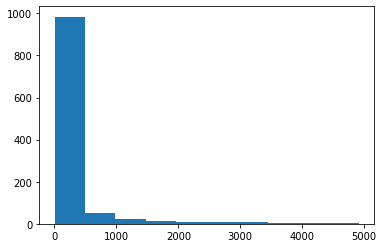

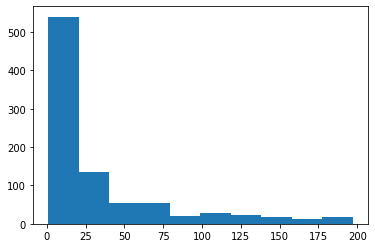

Median # of occurances in osha monitoring: 25


In [92]:
sub_counts[sub_counts < 5000].hist(grid=False)
plt.show()
sub_counts[sub_counts < 200].hist(grid=False)
plt.show()
print('Median # of occurances in osha monitoring: {:.0f}'.format(np.median(sub_counts)))

**IMIS code** isn't very meaningful without more info, but the substance column is poorly quality controlled, with some chemicals being named slightly differently.
Let's use fuzzy string matching to produce a list of the most commonly sampled substances by name.

In [100]:
counts_string = osha.substance.value_counts()
counts_string[counts_string < 1000].head()

Pyrene          977
DIACETYL        969
Isophorone      945
Phenanthrene    926
Cyclohexane     920
Name: substance, dtype: int64

In [90]:
osha

,inspection_number,establishment_name,city,state,zip_code,sic_code,naics_code,sampling_number,office_id,date_sampled,...,sample_type,blank_used,time_sampled,air_volume_sampled,sample_weight,imis_substance_code,substance,sample_result,unit_of_measurement,qualifier
0,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.24554e+06,214700.0,1984/05/07 00:00:00,...,P,N,258.0,516.0000,NaN,111211,Thorium,0.0005,M,NaN
1,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.24554e+06,214700.0,1984/05/07 00:00:00,...,P,Y,NaN,NaN,NaN,111211,Thorium,0.0000,NaN,BLK
2,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.2455e+06,214700.0,1984/05/07 00:00:00,...,P,N,38.0,76.0000,NaN,111211,Thorium,0.0160,M,NaN
3,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365.0,0.0,5.2455e+06,214700.0,1984/05/07 00:00:00,...,P,Y,NaN,NaN,NaN,111211,Thorium,0.0000,NaN,BLK
4,111252,MID ISLAND NON FERROUS FOUNDRY,East Farmingdale,NY,11735.0,3365.0,0.0,5.24534e+06,214700.0,1984/04/04 00:00:00,...,P,N,37.0,74.0000,0.0,111252,"Lead, Inorganic (as Pb)",0.0640,M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463708,806189446,NaN,NaN,NaN,NaN,NaN,NaN,WA20180202B,1055300.0,2018-JAN-23,...,P,N,58.0,57.652,NaN,806189446,p-Phenylene Diamine,0.0000,M,ND
2463709,806189446,NaN,NaN,NaN,NaN,NaN,NaN,WA20180202B,1055300.0,2018-JAN-23,...,P,Y,NaN,NaN,NaN,806189446,p-Phenylene Diamine,0.0000,X,BLK
2463710,Q130304018,NaN,NaN,NaN,NaN,NaN,NaN,CA2018060401,950662.0,2018-MAY-31,...,B,N,NaN,NaN,NaN,Q130304018,Soil,0.0000,N,NaN
2463711,Q130304018,NaN,NaN,NaN,NaN,NaN,NaN,CA2018060401,950662.0,2018-MAY-31,...,B,N,NaN,NaN,NaN,Q130304018,Soil,0.0000,N,NaN
